In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ssbc import generate_rigorous_pac_report
import ssbc

In [2]:
p_class1 = 0.30
beta_params_class0 = (2, 5)
beta_params_class1 = (5, 2)

alpha_0 = 0.10
delta_0 = 0.10
alpha_1 = 0.10
delta_1 = 0.10

N_samples = 1000

In [3]:
sim = ssbc.BinaryClassifierSimulator(
    p_class1=p_class1, beta_params_class0=beta_params_class0, beta_params_class1=beta_params_class1
)

In [4]:
labels, probs = sim.generate(N_samples)
class_data = ssbc.split_by_class(labels=labels, probs=probs)

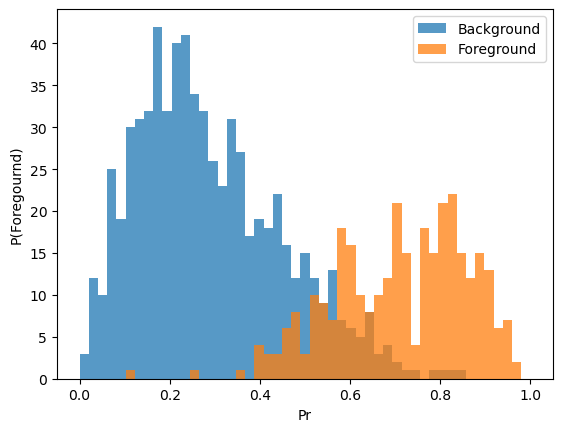

In [5]:
plt.hist(class_data[0]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.hist(class_data[1]["probs"][:, 1], bins=np.linspace(0, 1, 50), alpha=0.75)
plt.legend(["Background", "Foreground"])
plt.ylabel("P(Foregournd)")
plt.xlabel("Pr")
plt.savefig("tst.png")
plt.show()

In [6]:

# Generate report (now using SIMPLIFIED bounds)
report = generate_rigorous_pac_report(
    labels=labels,
    probs=probs,
    alpha_target=0.10,
    delta=0.10,
    test_size=N_samples,
    ci_level=0.95,
    use_union_bound=False,
    prediction_method="all",
    n_jobs=-1,
    verbose=True,
    loo_inflation_factor=2.5,
    use_loo_correction=True
    
)

Using provided LOO inflation factor: 2.500 (estimated from data: 1.002)
Using provided LOO inflation factor: 2.500 (estimated: 1.002) for comparison...
Using provided inflation factor for Hoeffding: 2.500
Using provided LOO inflation factor: 2.500 (estimated from data: 1.002)
Using provided LOO inflation factor: 2.500 (estimated: 1.002) for comparison...
Using provided inflation factor for Hoeffding: 2.500
Using provided LOO inflation factor: 2.500 (estimated from data: 2.000)
Using provided LOO inflation factor: 2.500 (estimated: 2.000) for comparison...
Using provided inflation factor for Hoeffding: 2.500
Using provided LOO inflation factor: 2.500 (estimated from data: 1.002)
Using provided LOO inflation factor: 2.500 (estimated: 1.002) for comparison...
Using provided inflation factor for Hoeffding: 2.500
Using provided LOO inflation factor: 2.500 (estimated from data: 1.002)
Using provided LOO inflation factor: 2.500 (estimated: 1.002) for comparison...
Using provided inflation fac

Using fixed thresholds: q̂₀=0.5410, q̂₁=0.5205
Running 100000 trials with test_size=1000...
Using all available CPU cores for parallel execution
PREDICTION INTERVAL VALIDATION RESULTS

Trials: 100000
Test size: 1000
Thresholds: q̂₀=0.5410, q̂₁=0.5205

MARGINAL

SINGLETON:
  Empirical mean: 0.9436
  Expected (LOO): 0.9420
  Quantiles:      [5%: 0.931, 25%: 0.939, 50%: 0.944, 75%: 0.949, 95%: 0.955]
  Selected bounds: [0.8940, 0.9760]
  Selected coverage: 100.0% ✅
  Method-specific validation:
    Analytical  : [0.9149, 0.9691] (width: 0.0543, coverage: 100.0%) ✅
    Exact       : [0.8940, 0.9760] (width: 0.0820, coverage: 100.0%) ✅
    Hoeffding   : [0.8212, 1.0000] (width: 0.1788, coverage: 100.0%) ✅

DOUBLET:
  Empirical mean: 0.0564
  Expected (LOO): 0.0580
  Quantiles:      [5%: 0.045, 25%: 0.051, 50%: 0.056, 75%: 0.061, 95%: 0.069]
  Selected bounds: [0.0240, 0.1060]
  Selected coverage: 100.0% ✅
  Method-specific validation:
    Analytical  : [0.0309, 0.0851] (width: 0.0543, cover

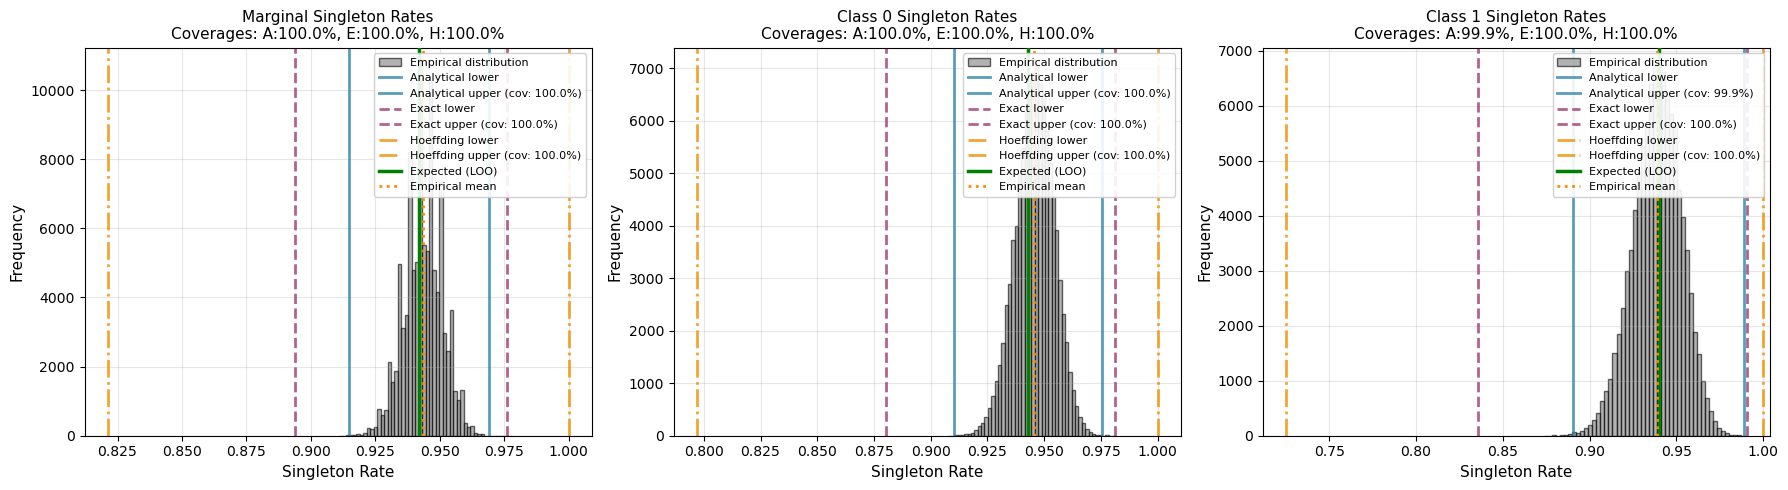

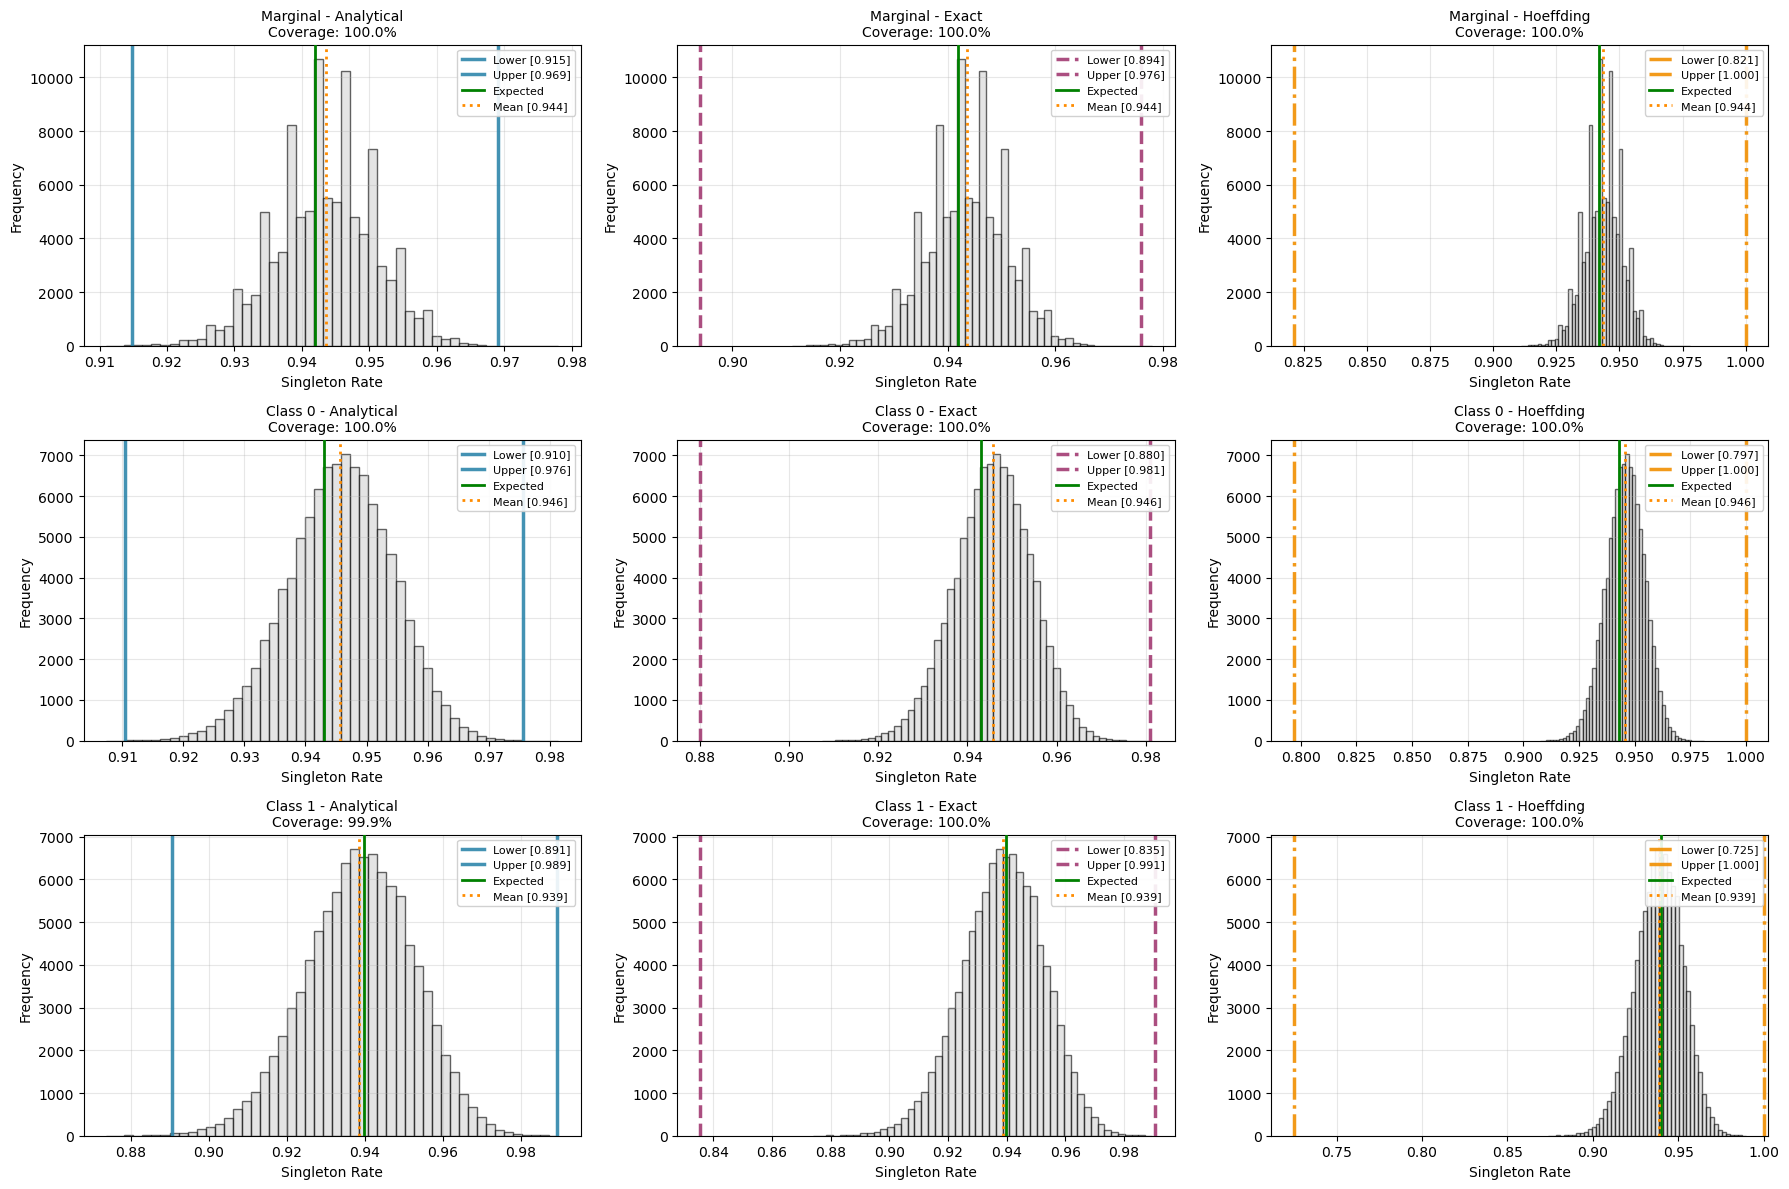

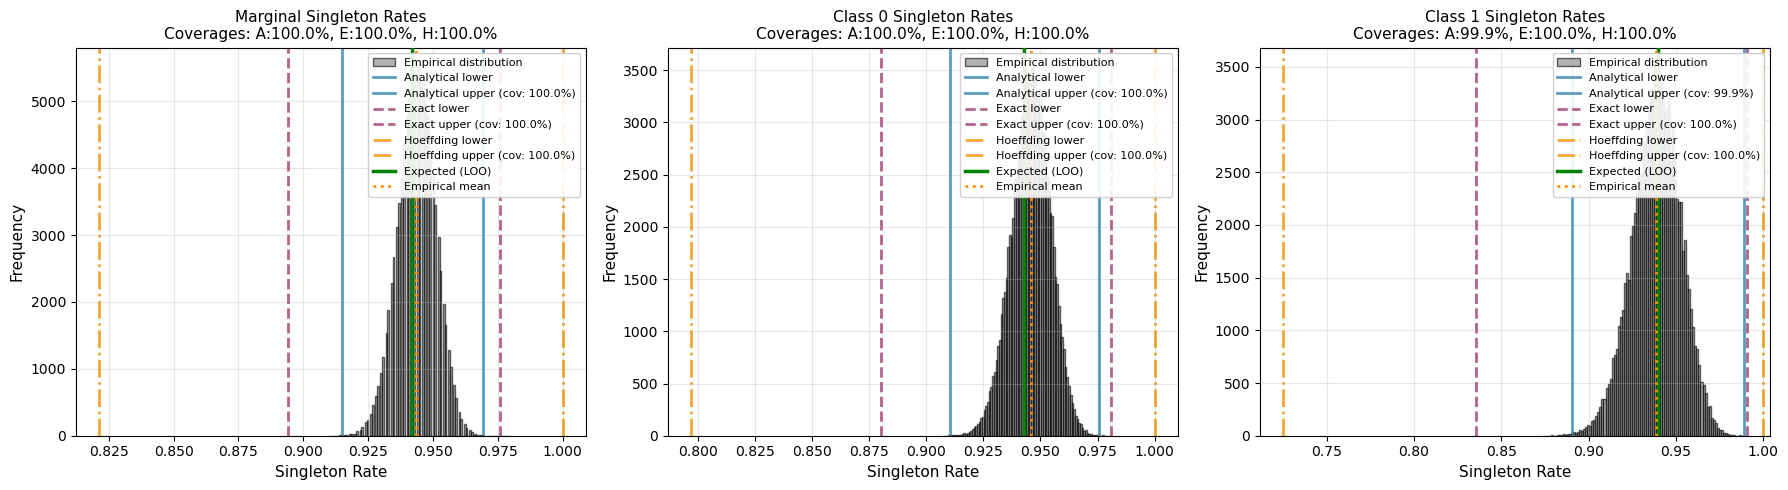

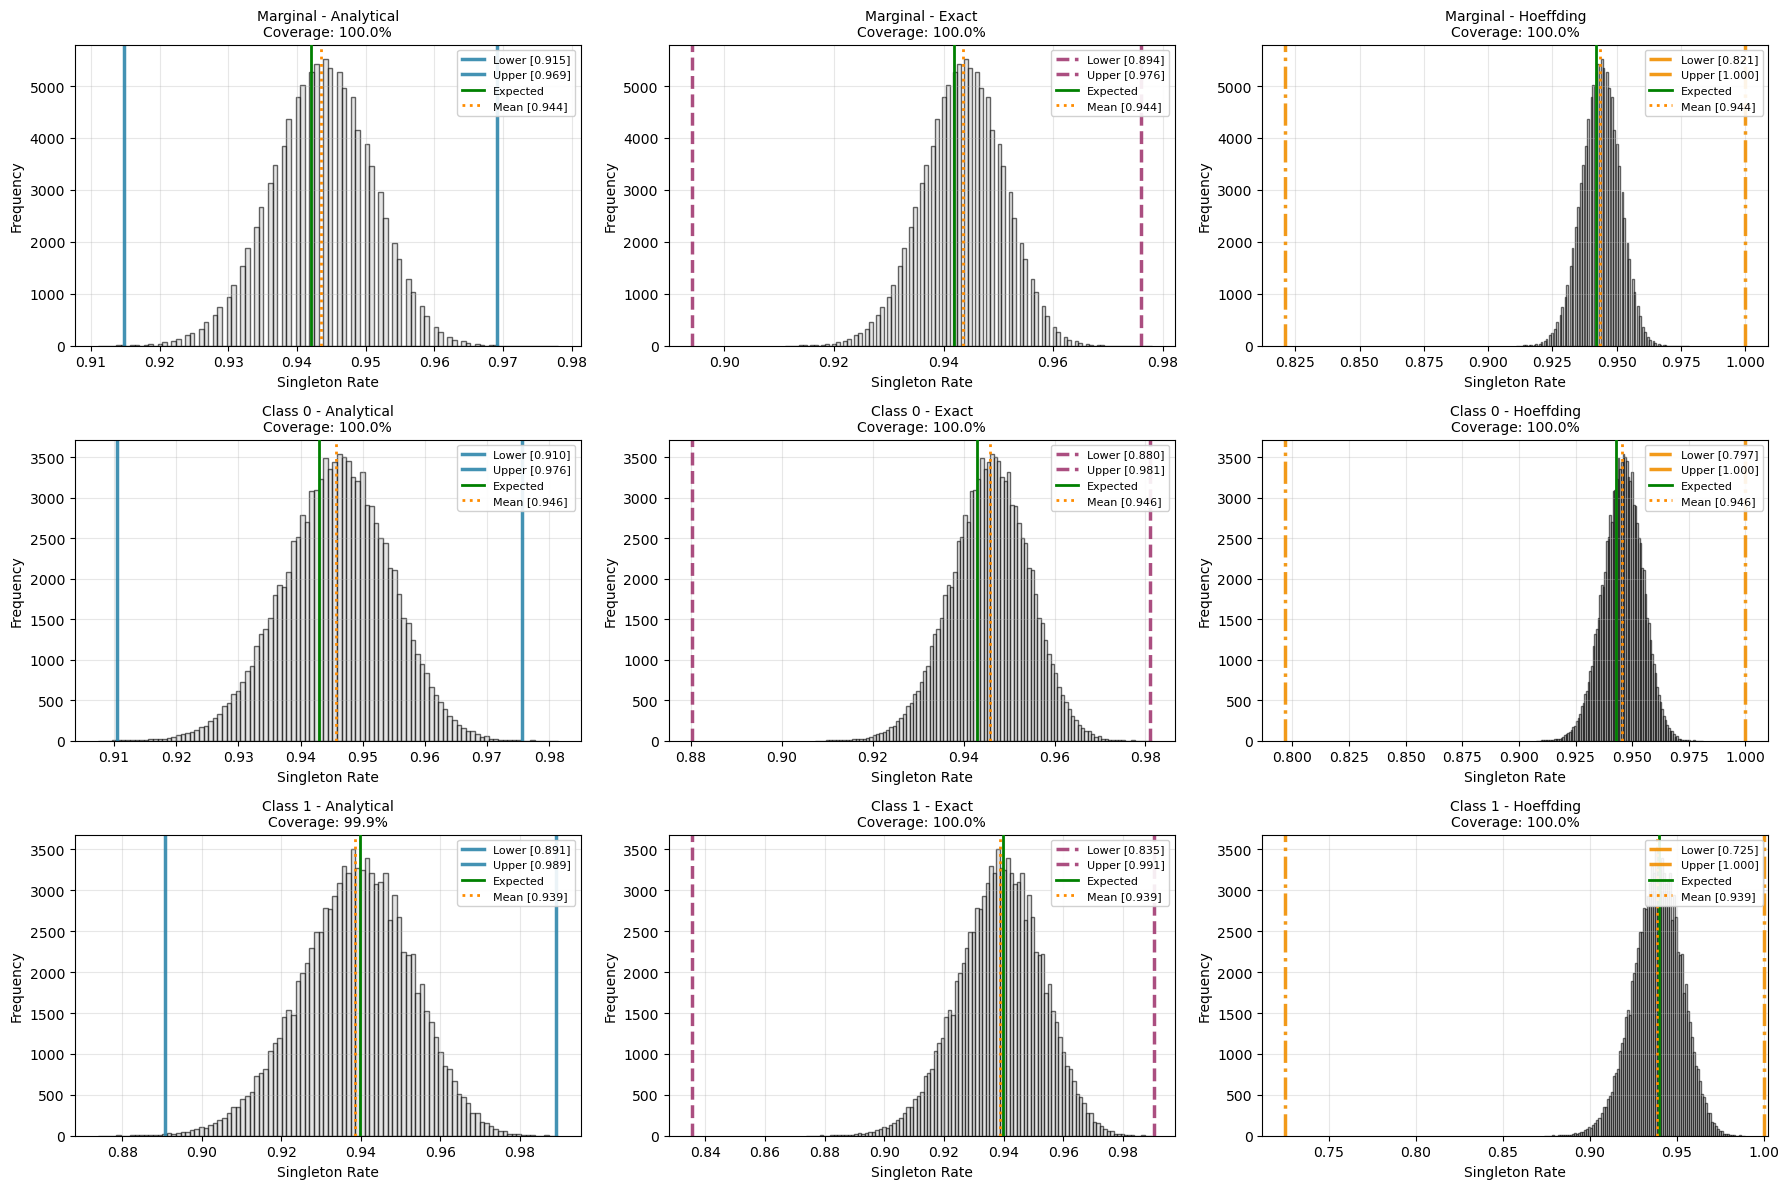

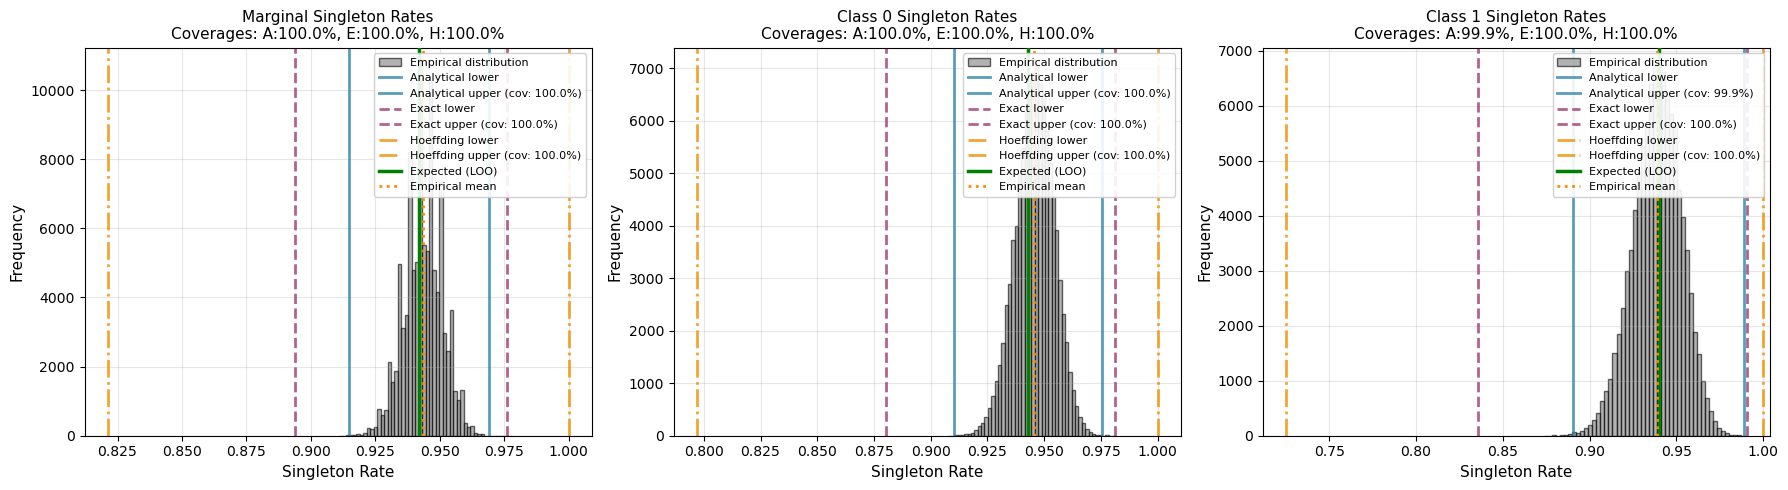

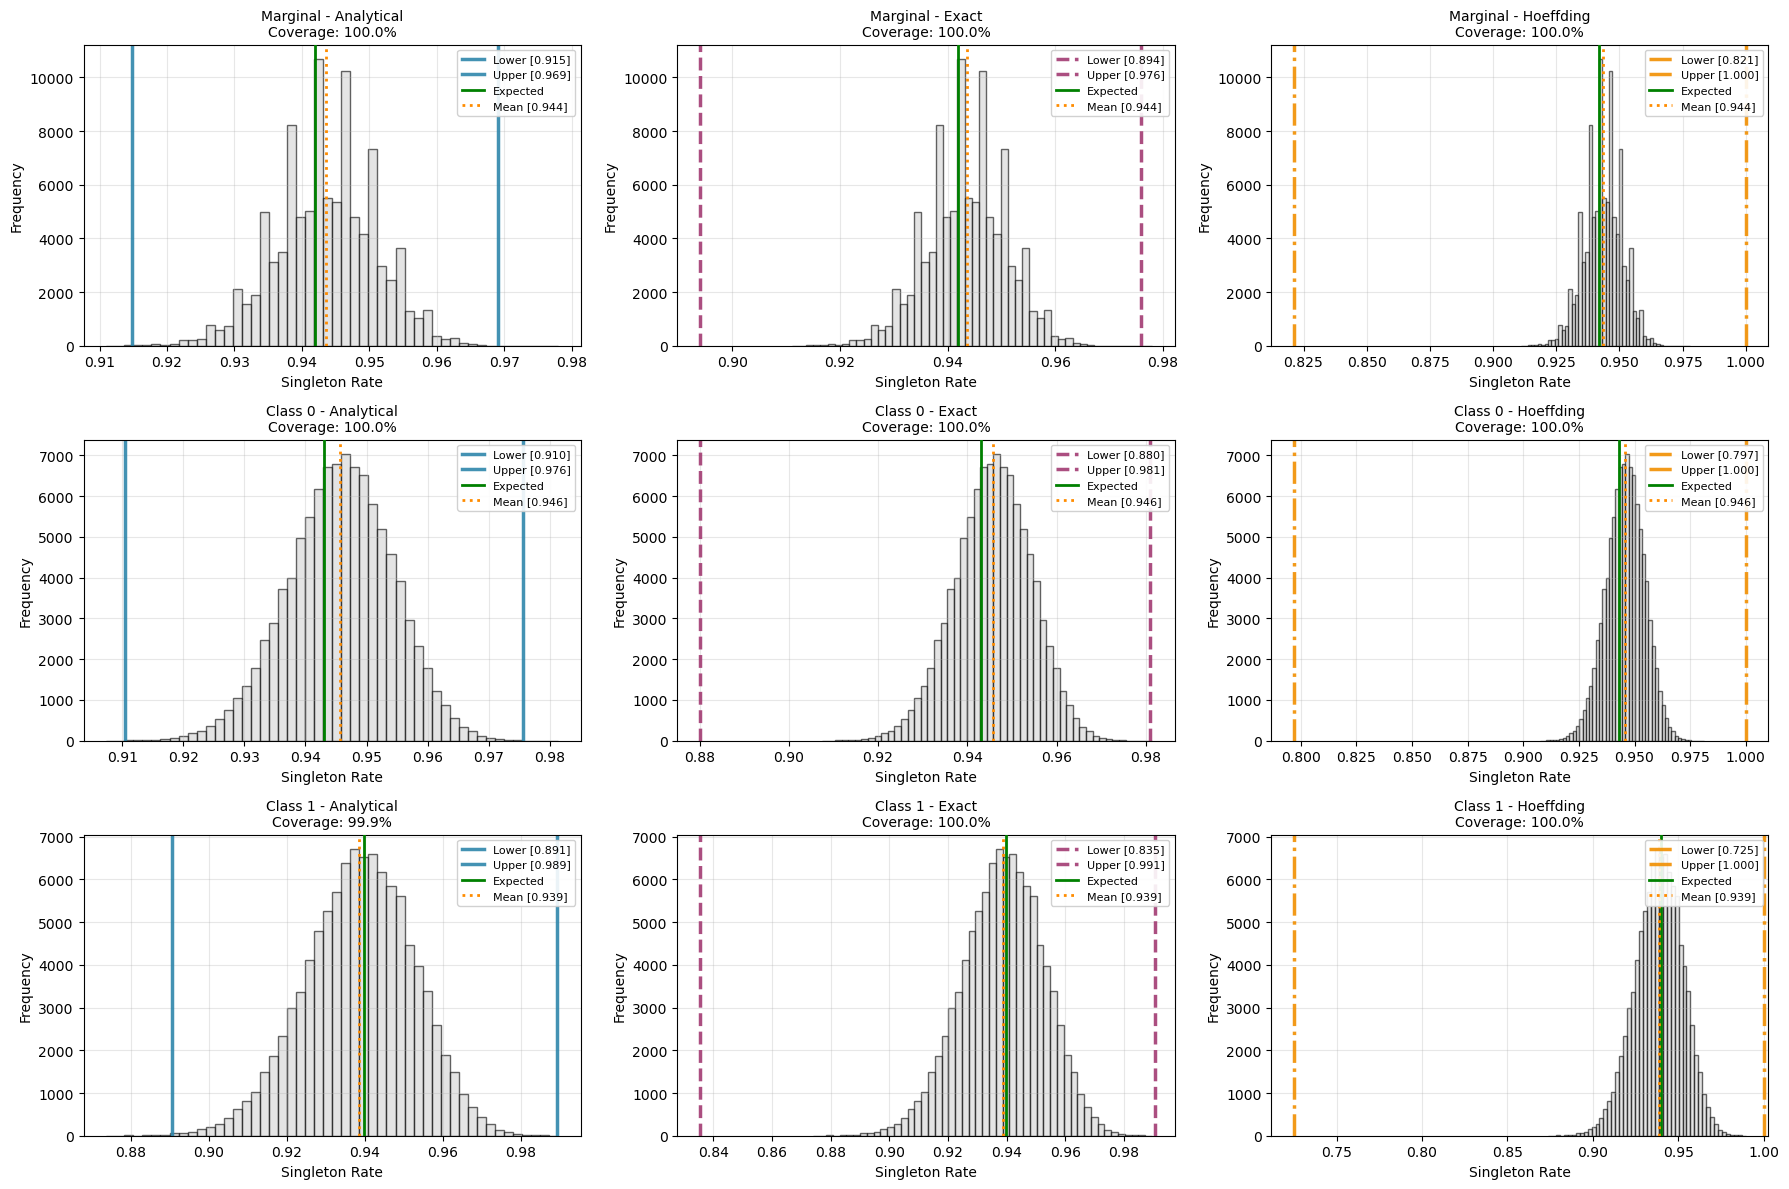

In [7]:
validation = ssbc.validate_pac_bounds(
    report=report,
    simulator=sim,
    test_size=N_samples,      # Size of each test set
    n_trials=100000,       # Number of independent trials (increase for better stats)
    seed=42,             # For reproducibility
    verbose=True,
    n_jobs=-1,           # Use all CPU cores
)

ssbc.print_validation_results(validation)


from ssbc import plot_validation_bounds

# Simple usage
plot_validation_bounds(validation, metric="singleton")

# Customize
plot_validation_bounds(
    validation, 
    metric="singleton", 
    show_detail=True,
    bins=100,
    return_figs=False
)

# Or get figures for saving/customization
fig_main, fig_detail = plot_validation_bounds(
    validation, 
    metric="singleton", 
    return_figs=True
)


In [ ]:
results = ssbc.validate_prediction_interval_calibration(
    simulator=sim,
    n_calibration=N_samples,        # Size of each calibration dataset
    BigN=5000,                  # Number of different calibrations to test
    n_trials=5000,             # Test sets per calibration
    test_size=N_samples,
    ci_level=0.95,
    prediction_method="all",  # Compare all methods
    use_loo_correction=True,
    loo_inflation_factor=2.0,
    verbose=False,            # Minimal printouts
    n_jobs=-1,
)

In [ ]:
# Print results
ssbc.print_calibration_validation_results(results)

In [ ]:
from ssbc import validate_prediction_interval_calibration, get_calibration_bounds_dataframe

# Run meta-validation


# Extract DataFrame
df = get_calibration_bounds_dataframe(results)

# Filter specific datasets
df_single = df[(df['scope'] == 'class_0') & (df['metric'] == 'singleton')]

# Plot lower bounds comparison
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Lower quantiles
ax1.scatter(df_single['analytical_lower'], df_single['observed_q05'], label='Analytical', alpha=0.6)
ax1.scatter(df_single['exact_lower'], df_single['observed_q05'], label='Exact', alpha=0.6)
ax1.plot([0.90, 1], [0.90, 1], 'k--', label='Perfect')
ax1.set_xlabel('Predicted Lower Bound')
ax1.set_ylabel('Observed 5th Percentile')
ax1.legend()

# Upper quantiles  
ax2.scatter(df_single['analytical_upper'], df_single['observed_q95'], label='Analytical', alpha=0.6)
ax2.scatter(df_single['exact_upper'], df_single['observed_q95'], label='Exact', alpha=0.6)
ax2.plot([0.9, 1], [0.90, 1], 'k--', label='Perfect')
ax2.set_xlabel('Predicted Upper Bound')
ax2.set_ylabel('Observed 95th Percentile')

ax2.legend()

In [ ]:
from ssbc import (
    validate_prediction_interval_calibration,
    get_calibration_bounds_dataframe,
    plot_calibration_excess,
)
# Plot excess for singleton marginal
df_single = df[(df['scope'] == 'marginal') & (df['metric'] == 'singleton')]
plot_calibration_excess(df_single, scope='marginal', metric='singleton')

# Or directly filter in the function
plot_calibration_excess(df, scope='marginal', metric='singleton', methods=['analytical', 'exact'])